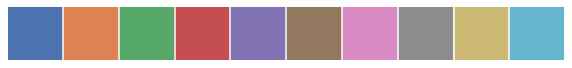

In [439]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('talk')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)
import json
from pandas.io.json import json_normalize
current_palette = sns.color_palette()
sns.palplot(current_palette)

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox.expanded(1.05,1.4))

In [898]:
labels = ['ResNet', 'DenseNet', 'B-ResNet', 'B-DenseNet', 'MSDNet']
models = ['resnet', 'densenet', 'b-resnet', 'b-densenet', 'msdnet']
platforms = ['gpu', 'jetson', 'nuc']

In [847]:
results = {
    platform : {
        model : pd.read_json(platform + '_local_'  + model + '.json') for model in models 
    } for platform in platforms
}

In [848]:
results['nuc']['b-densenet'] = pd.read_json('nuc' + '_local_'  + 'b-densenet' + '2' + '.json')

In [849]:
results['jetson']['b-densenet'] = pd.read_json('jetson' + '_local_'  + 'b-densenet' + '2' + '.json')

In [850]:
np.cumsum(results['jetson']['b-densenet'][4:].groupby('exit').time.max().tolist())


array([ 17.308576,  47.538935,  87.812975, 120.286752])

In [851]:
stats = {
    platform : {
        model : {} for model in models
    } for platform in platforms
    
}
for platform in platforms:
    for exits, model in zip([1,1,4,4,5], models):
        stats[platform][model]['mean'] = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.mean())).tolist()
        stats[platform][model]['std']  = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.std())).tolist()
        stats[platform][model]['min']  = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.min())).tolist()
        stats[platform][model]['max']  = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.max())).tolist()

In [852]:
pd.DataFrame(stats['jetson']['resnet'])

,mean,std,min,max
0,64.191961,1.951852,61.280718,110.165094


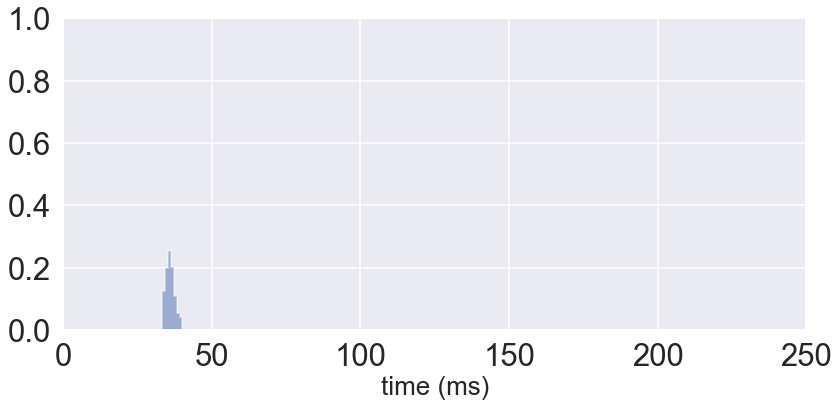

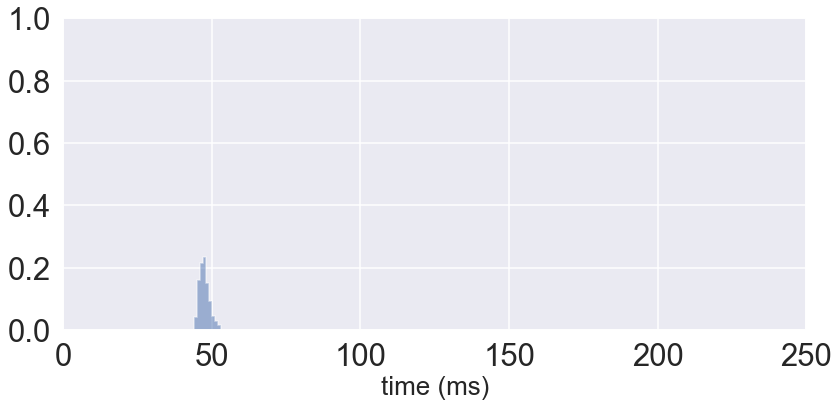

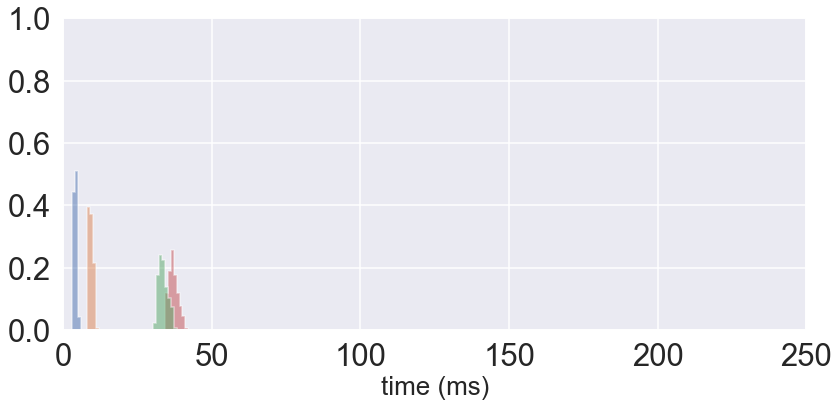

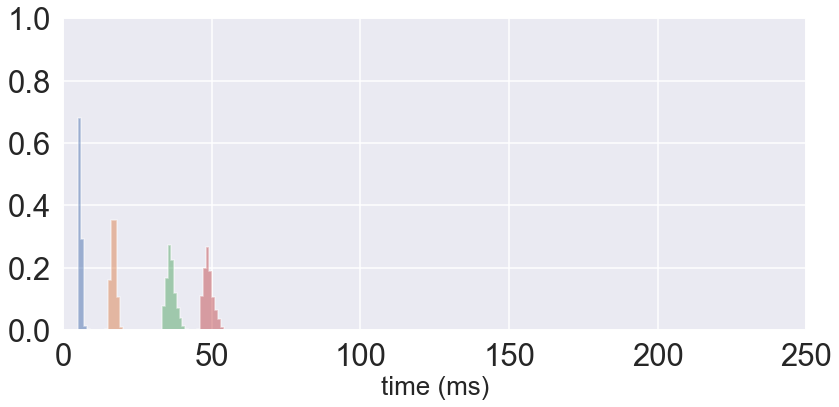

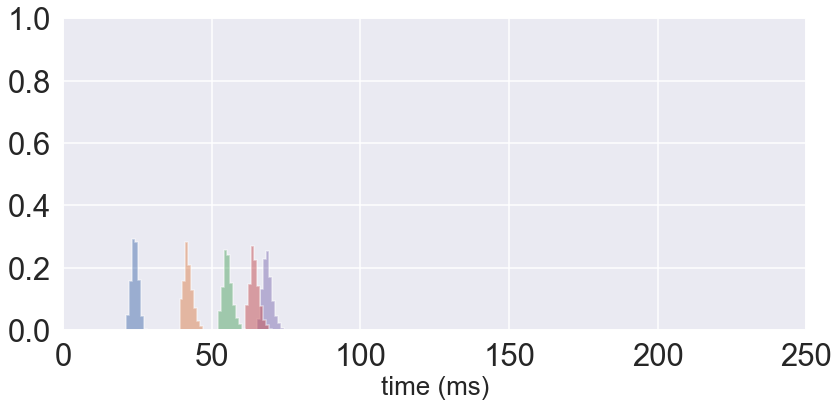

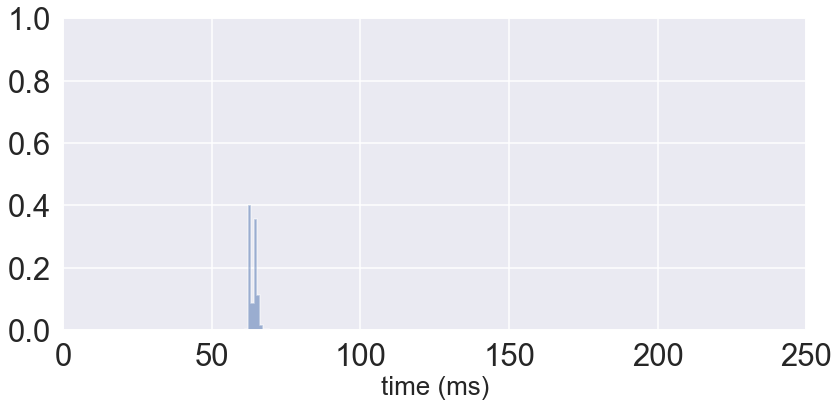

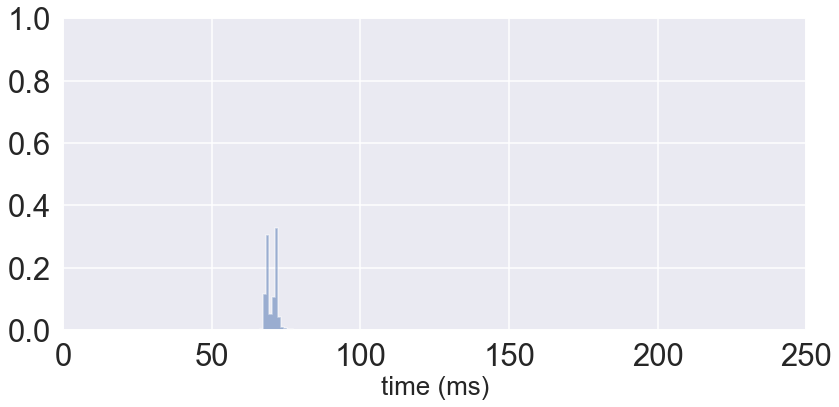

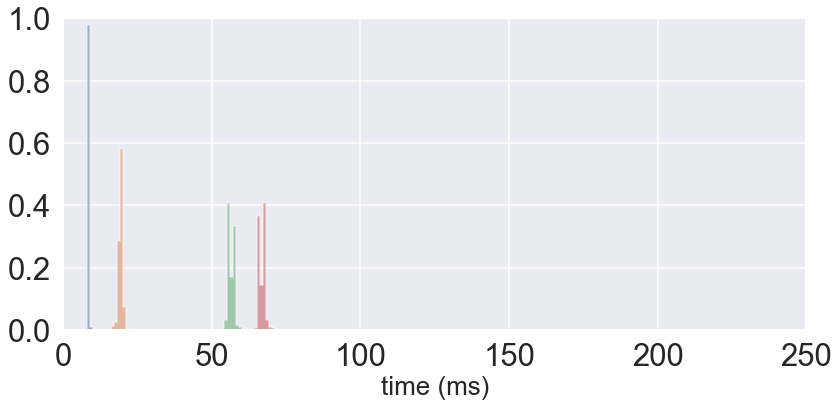

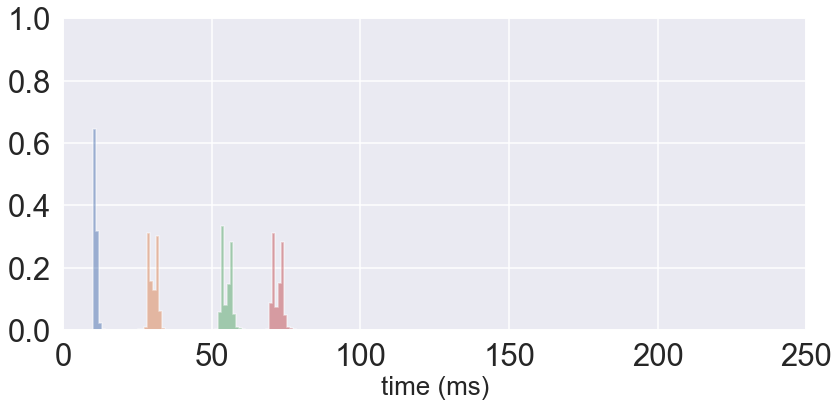

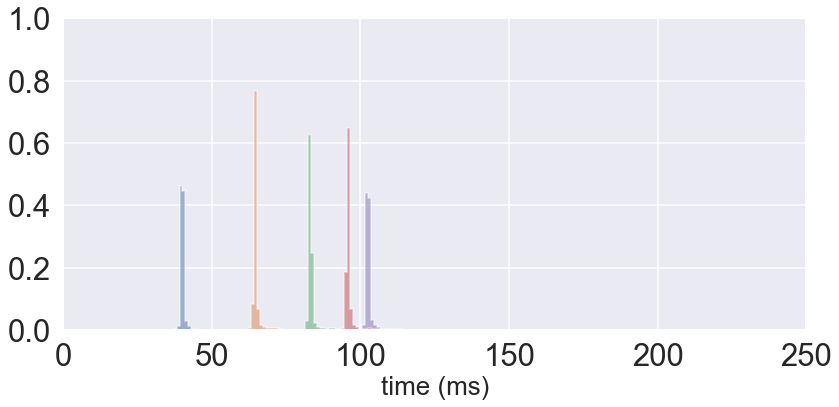

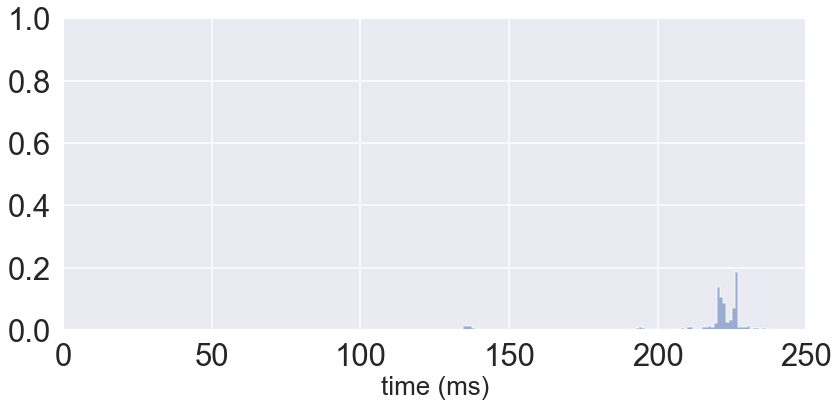

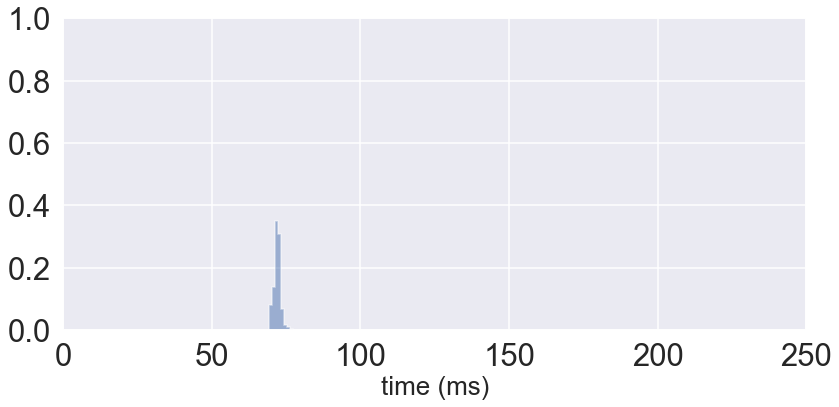

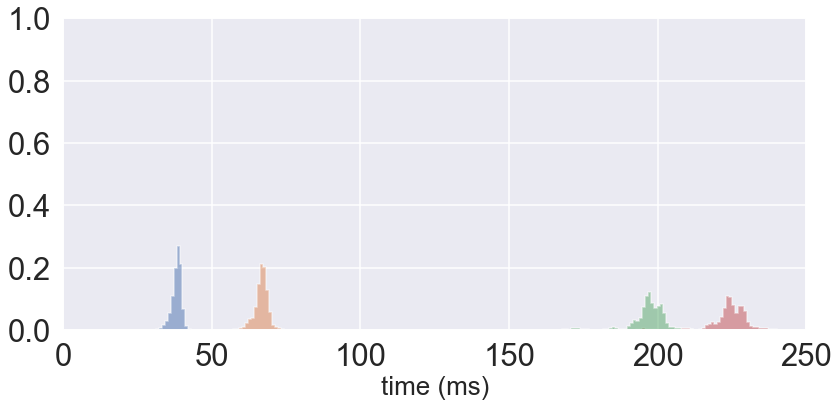

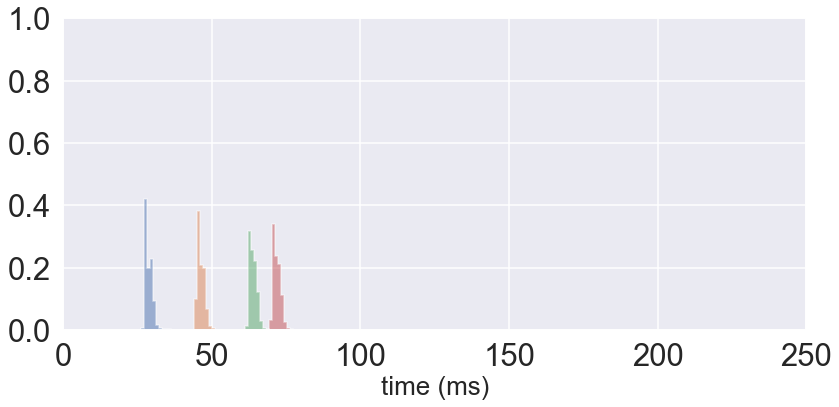

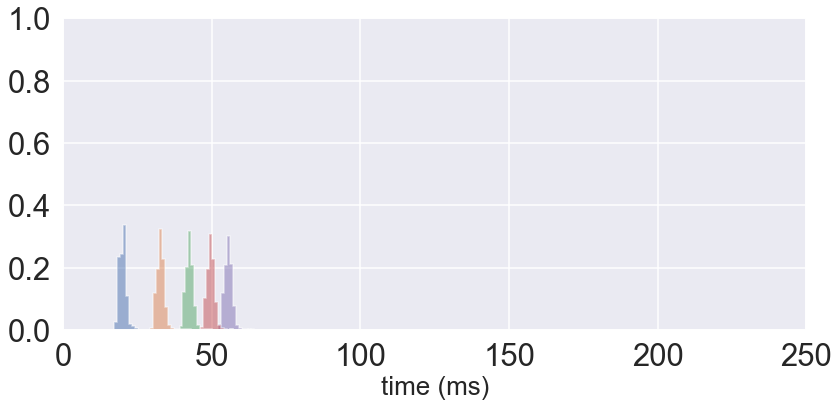

In [230]:
for platform in platforms:
    for model in models:
        fig, axes = plt.subplots(1,1, figsize=(12,6))
        axes.set_xlim([0,250])
        axes.set_ylim([0,1])
        bins = np.linspace(0,250,250)
        
        if model == 'b-resnet' or model == 'b-densenet':
            exits = 4
        elif model == 'msdnet':
            exits = 5
        else:
            exits = 1
            
        time_data = np.zeros((exits,5000))
        for sample, (exit, data) in enumerate(results[platform][model].groupby('exit')):
            time_data[exit]= data.time
        time_data = np.cumsum(time_data, axis=0)
        axes.hist(time_data.T, bins, density=True, histtype='stepfilled',alpha=0.5)

        axes.set_xlabel('time (ms)', fontsize='x-large')
        axes.tick_params(labelsize='xx-large')
        #axes.set_yticks(np.arange(0,1.1,0.25))
        fig.tight_layout()

        plt.savefig(platform + '_' + model + '_inference_time_distribution.png')

In [430]:
results_th = {
    platform : {
        model : pd.read_json(platform + '_local_'  + model + '_analysis.json') for model in models
    } for platform in platforms
}

In [839]:
results_th['jetson']['resnet'].loc[]

,Delay Threshold,Exit,N,latest,missed
60,63,[1486.0],5000,0.2772,3514
61,64,[2380.0],5000,0.4440,2620
62,65,[3680.0],5000,0.6840,1320
63,66,[4780.0],5000,0.8884,220
64,67,[4891.0],5000,0.9090,109
65,68,[4924.0],5000,0.9152,76
66,69,[4942.0],5000,0.9186,58
67,70,[4951.0],5000,0.9204,49
68,71,[4957.0],5000,0.9212,43
69,72,[4960.0],5000,0.9216,40


In [432]:
len(results_th['nuc']['b-resnet'])-len(results_th['nuc']['msdnet'])

0

In [407]:

longest = 0
for model in models[2:5]:
    if len(results_th['nuc'][model]) > longest:
        longest = len(results_th['nuc'][model])

In [836]:
np.array(results_th['jetson'][model]['latest']

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 6.000e-04, 6.000e-04, 6.000e-04,
       6.000e-04, 1.400e-03, 1.400e-03, 1.400e-03, 4.200e-03, 4.200e-02,
       3.530e-01, 4.338e-01, 4.766e-01, 7.922e-01, 8.710e-01, 8.812e-01,
       8.888e-01, 8.934e-01, 8.972e-01, 8.994e-01, 9.006e-01, 9.020e-01,
       9.036e-01, 9.046e-01, 9.052e-01, 9.058e-01, 

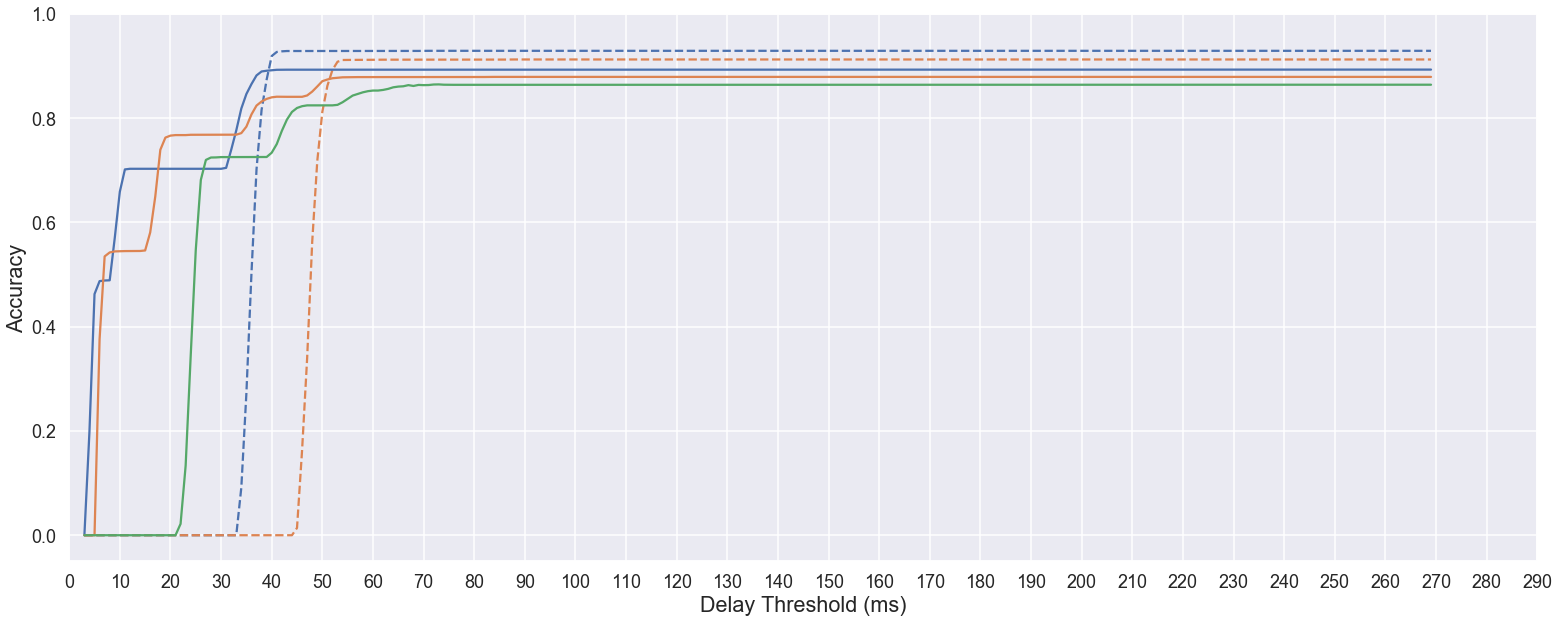

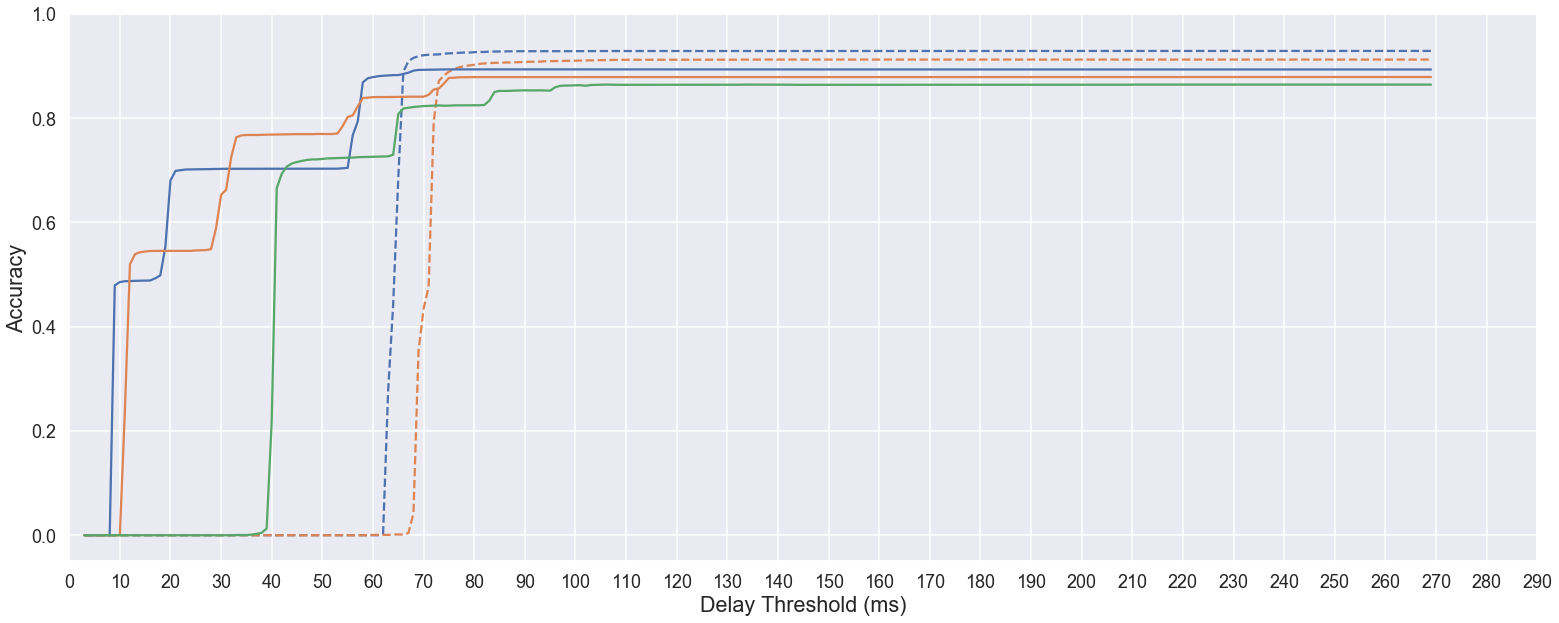

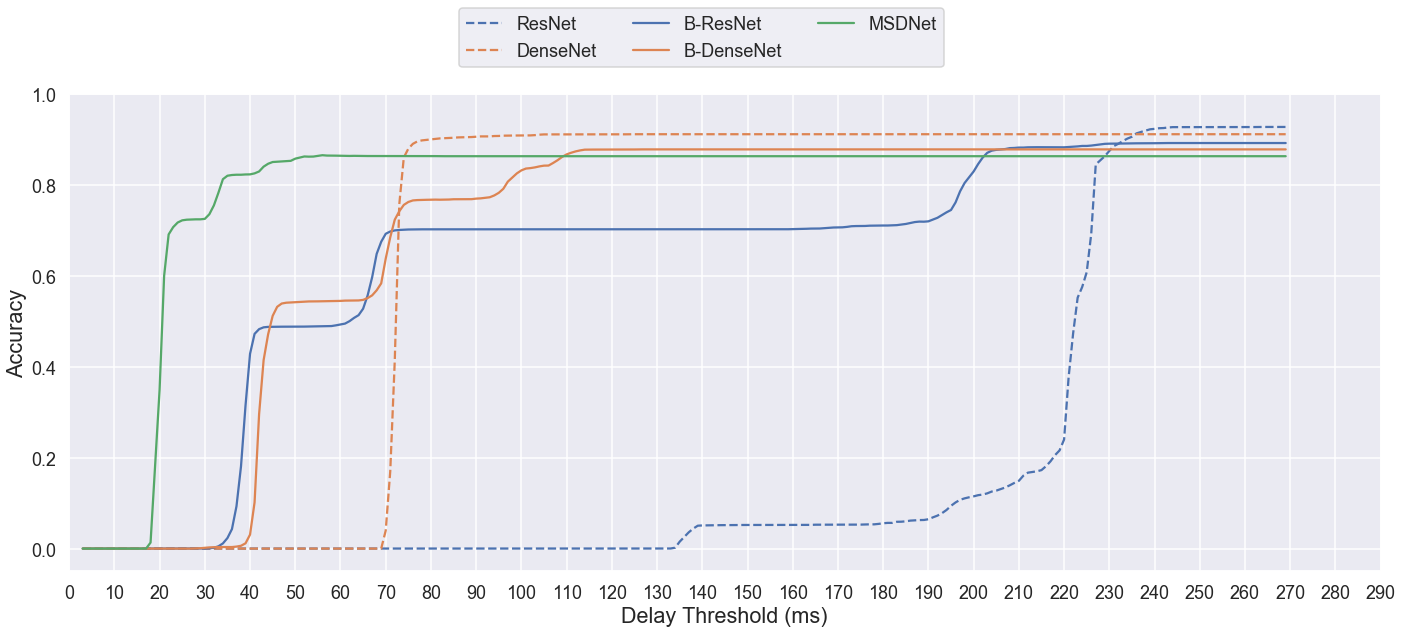

In [869]:
for platform in platforms:
    fig, axes = plt.subplots(1,1, figsize=(22,9))
    for model, color in zip(models[:2],[0,1]):
        axes.plot(results_th[platform][model]['Delay Threshold'],results_th[platform][model]['latest'], '--', color=current_palette[color])
    for model, color in zip(models[2:],[0,1,2]):
        axes.plot(results_th[platform][model]['Delay Threshold'],results_th[platform][model]['latest'], color=current_palette[color])
    axes.set_ylim([-0.05,1])
    axes.set_xlim([-0.1,250])
    axes.set(xlabel='Delay Threshold (ms)', ylabel='Accuracy')
    axes.set_xticks(np.arange(0,300,10))
    #fig.legend(ncol=5, 
    #           loc="upper center", fontsize='small')
    fig.tight_layout()
    
    
    plt.savefig(platform + '_' + '_delay_threshold.png')
fig.subplots_adjust(top=0.85, left=0.15)  
legend = fig.legend(labels, ncol=3, loc="upper center", fontsize='medium')
export_legend(legend, filename='delay_threshold_legend.png')

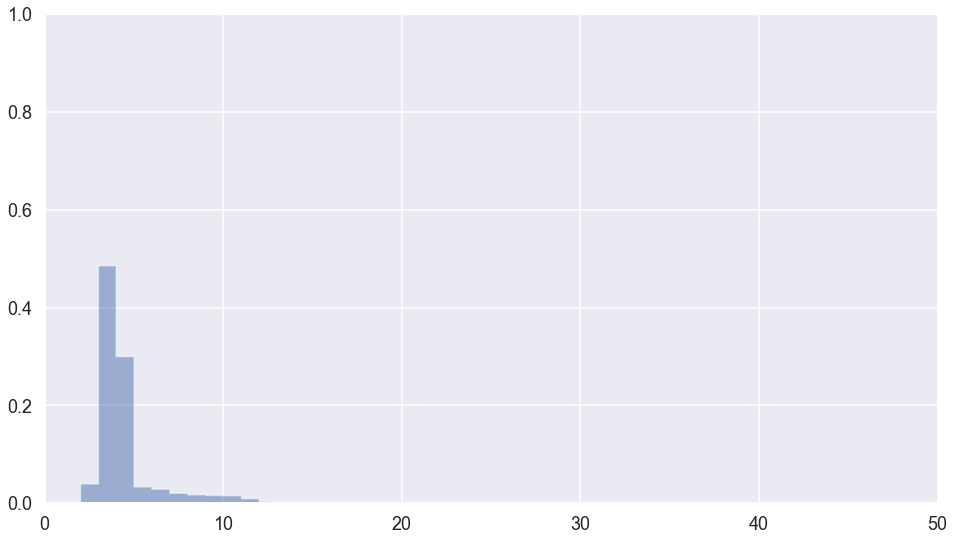

In [692]:
timings = pd.read_json('../edge_test/nuc_2_jetson_b-resnet_time_timing2.json')
fig, ax = plt.subplots(1)
ax.set_xlim([0,50])
ax.set_ylim([0,1])
bins = np.linspace(0,500,500)
plot1 = ax.hist(timings.time, bins, density=True, histtype='stepfilled',alpha=0.5)


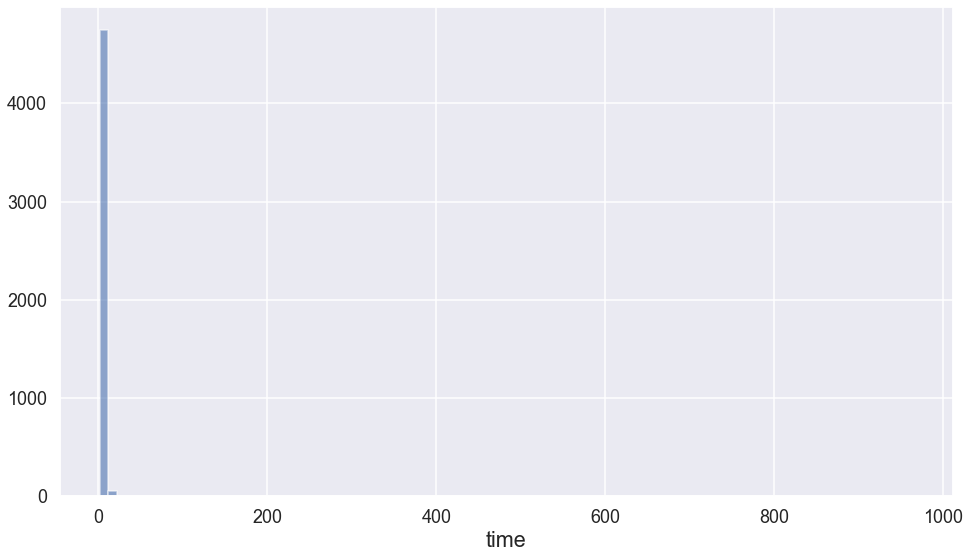

In [706]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2, 'shade': True}, hist=True, kde=False, bins=100)
fig, ax = plt.subplots(1)

sns.distplot(timings.time, **kwargs)

In [703]:
time_stats = {'mean': timings.time.mean(),
             'std': timings.time.std(),
             'max': timings.time.max(),
             'min': timings.time.min()}
time_stats

{'mean': 25.675386722298573,
 'std': 110.93056984024832,
 'max': 962.7591060125269,
 'min': 2.352067007450387}

In [875]:
import json
for model, exits in zip(models,[1,1,4,4,5]):
    #print(model)
    offload_time = np.zeros((5000,exits))
    for (i, d), (j,t) in zip(results['gpu'][model].groupby('sample'),timings.groupby('sample')):
        #print(np.cumsum(np.array(d.time.tolist())),t.time.tolist()[0])
        
        offload_time[i] = (np.cumsum(np.array(d.time.tolist()))+t.time.tolist()[0])
        #print(offload_time[i])

    with open('jetson_local_' + model + '.json', 'r') as f:
        data = f.read()
    data = json.loads(data)
    for d, t in zip(data, offload_time.flatten()):
        #print('local: {}'.format(d['time']))
        d['time'] = t
        #print('edge: {}'.format(d['time']))
    with open('gpu_' + model + '_offload.json', 'w') as json_file:
        json.dump(data, json_file)

In [881]:
results_offload = {
    platform : {
        model : pd.read_json('../edge_test/' + platform + '_merge_'  + model + '_analysis.json') for model in models
    } for platform in platforms[:2]
}
print(results_offload['jetson']['resnet'][50:100])

    Delay Threshold      Exit     N  latest  missed
50               60     [0.0]  5000  0.0000    5000
51               61     [0.0]  5000  0.0000    5000
52               62     [0.0]  5000  0.0000    5000
53               63     [0.0]  5000  0.0000    5000
54               64     [1.0]  5000  0.0002    4999
55               65     [8.0]  5000  0.0014    4992
56               66   [196.0]  5000  0.0360    4804
57               67  [1274.0]  5000  0.2382    3726
58               68  [2138.0]  5000  0.4002    2862
59               69  [3194.0]  5000  0.5958    1806
60               70  [4037.0]  5000  0.7518     963
61               71  [4237.0]  5000  0.7882     763
62               72  [4380.0]  5000  0.8152     620
63               73  [4484.0]  5000  0.8350     516
64               74  [4575.0]  5000  0.8520     425
65               75  [4633.0]  5000  0.8620     367
66               76  [4680.0]  5000  0.8710     320
67               77  [4709.0]  5000  0.8764     291
68          

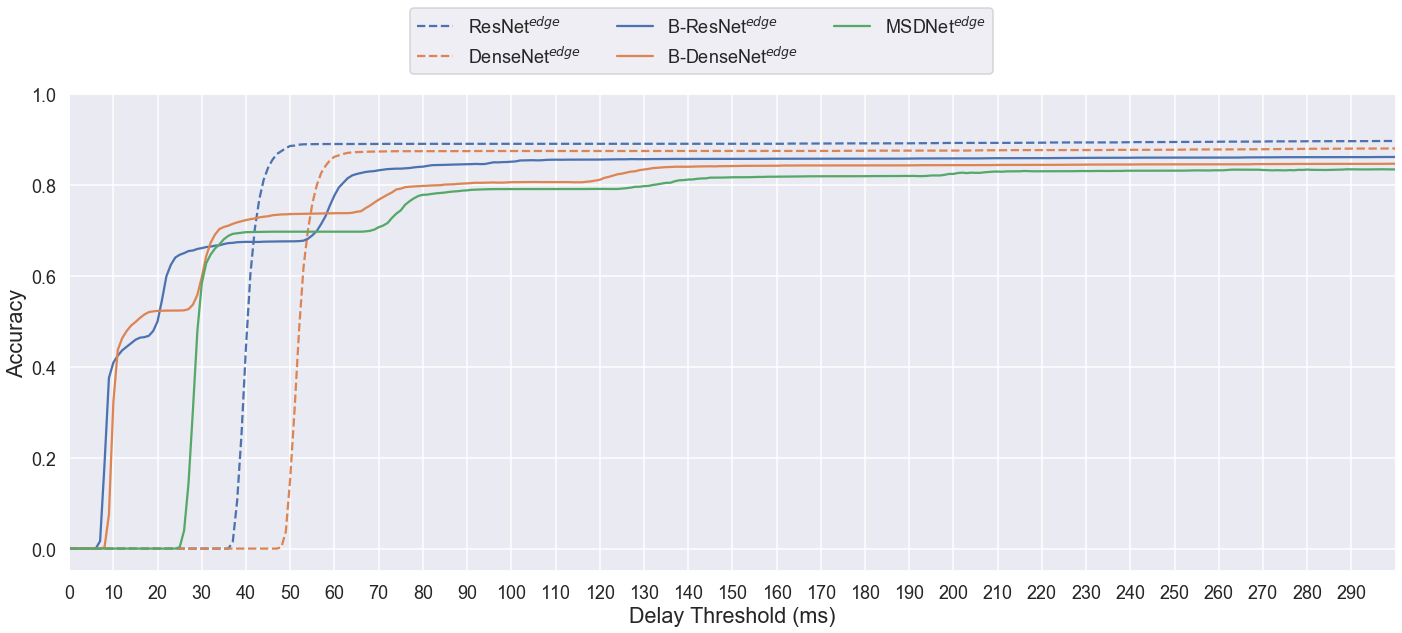

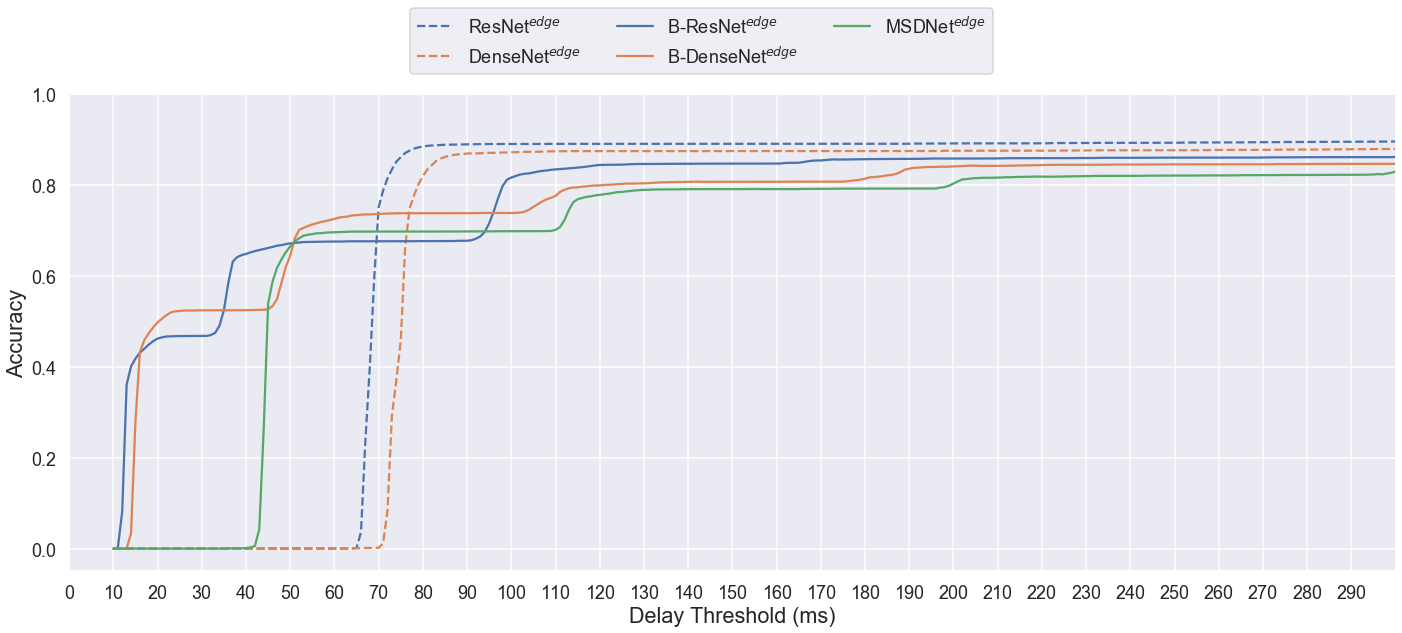

In [882]:
for platform in platforms[:2]:
    fig, axes = plt.subplots(1,1, figsize=(22,9))
    #for model, color in zip(models[:2],[0,1]):
    #    axes.plot(results_offload[model]['Delay Threshold'],results_offload[model]['latest'], '--', color=current_palette[color])
    for model, color, line in zip(models,[0,1,0,1,2],['--','--','-','-','-']):
        axes.plot(results_offload[platform][model]['Delay Threshold'],results_offload[platform][model]['latest'], line, color=current_palette[color])
    axes.set_ylim([-0.05,1])
    axes.set_xlim([-0.1,300])
    axes.set_xticks(np.arange(0,300,10))
    axes.set(xlabel='Delay Threshold (ms)', ylabel='Accuracy')
    #fig.legend(ncol=5, 
    #           loc="upper center", fontsize='small')
    fig.tight_layout()


    plt.savefig(platform + '_' + 'offloading.png')
    fig.subplots_adjust(top=0.85, left=0.15)  
    legend = fig.legend([label + '$^{edge}$' for label in labels], ncol=3, loc="upper center", fontsize='medium')
    export_legend(legend, 'offloading_legend.png')

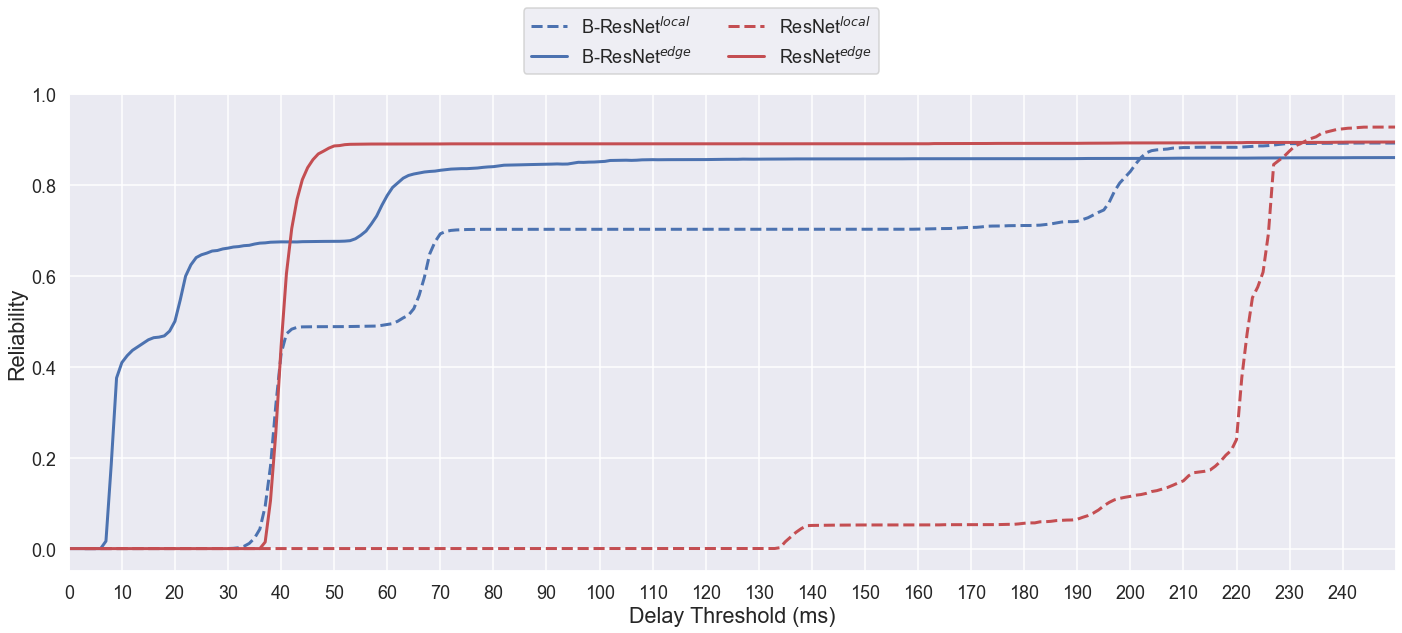

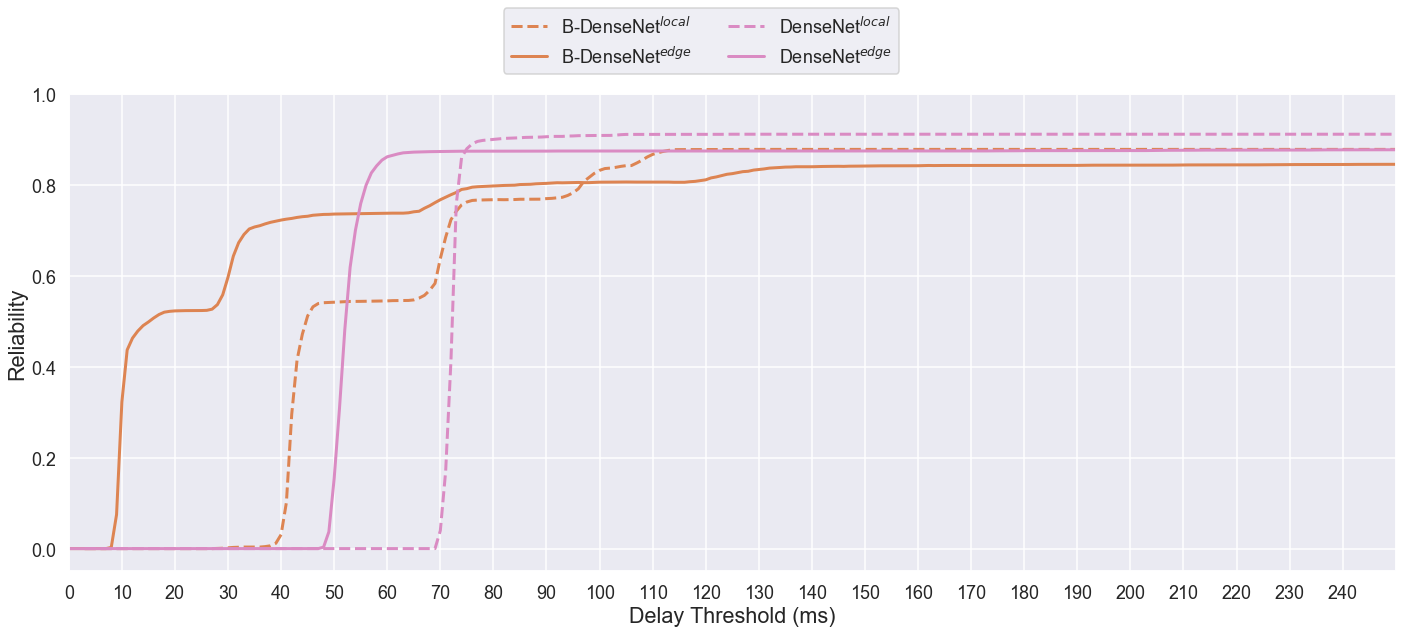

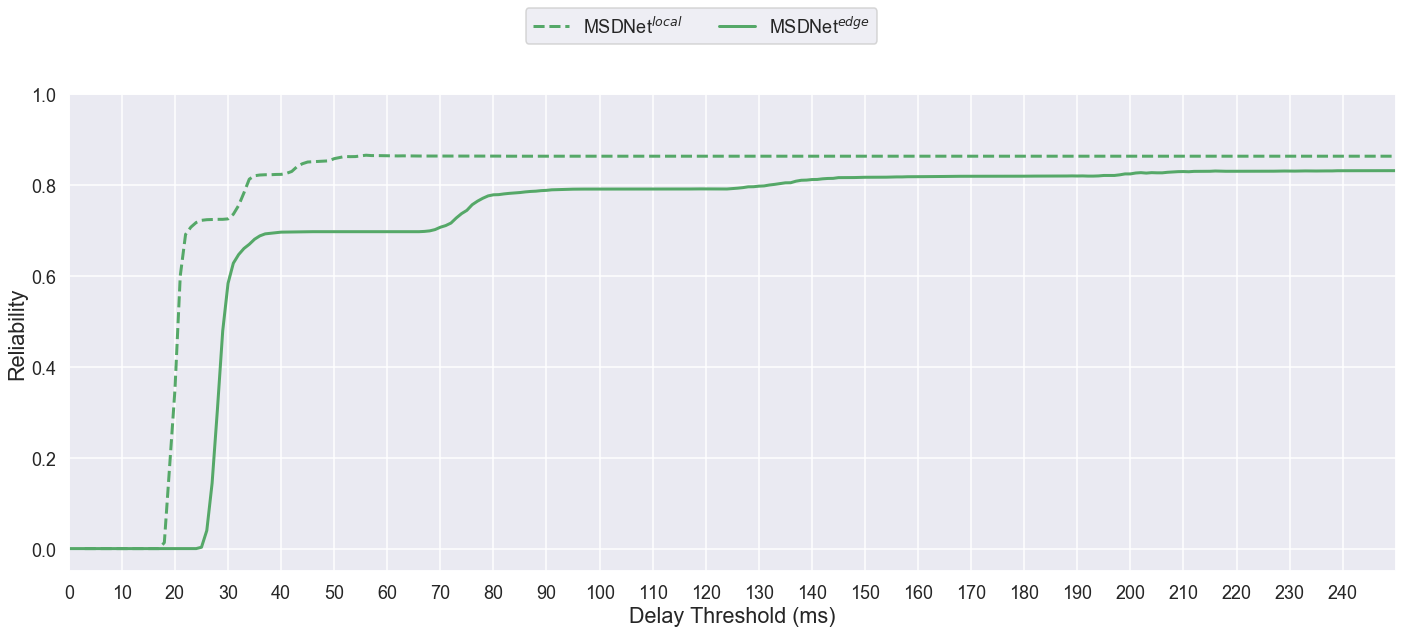

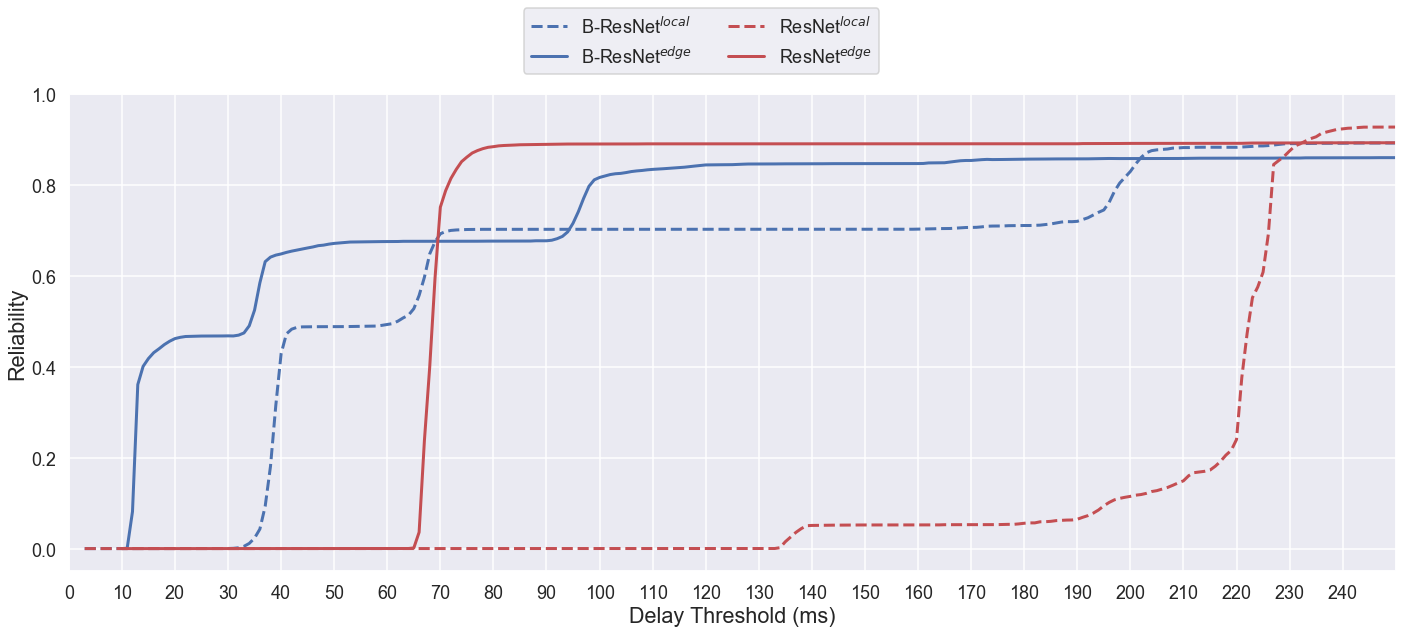

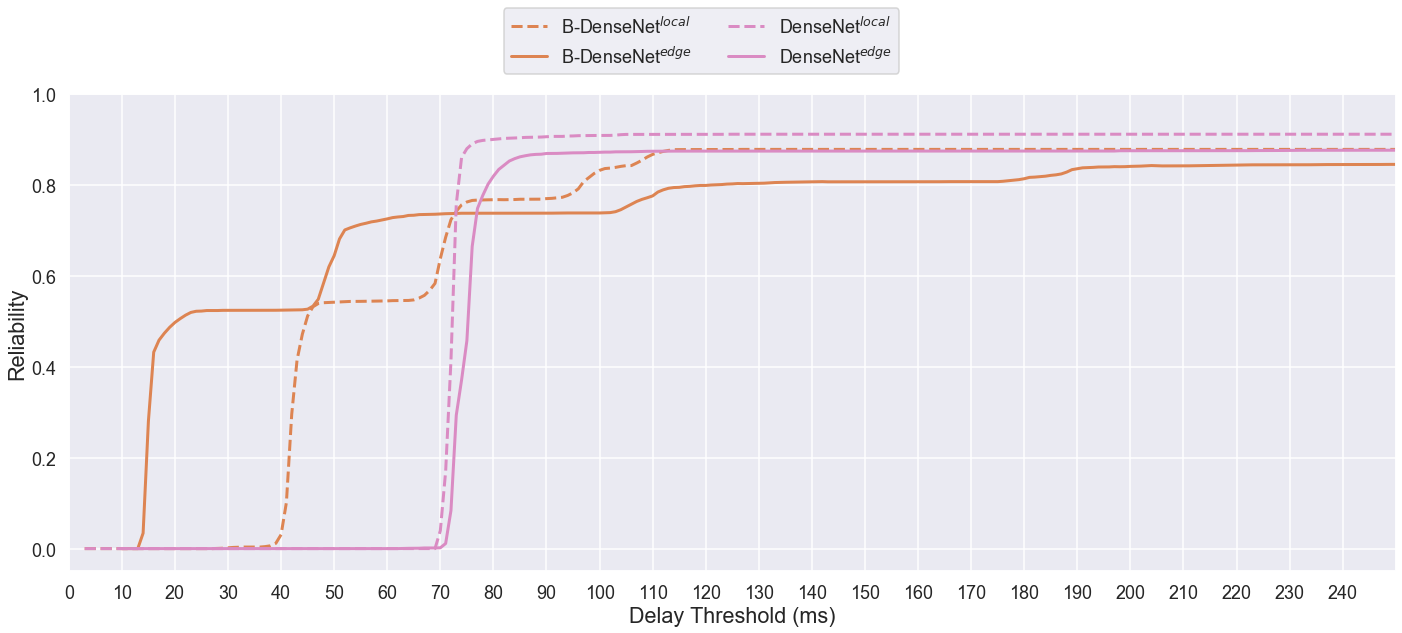

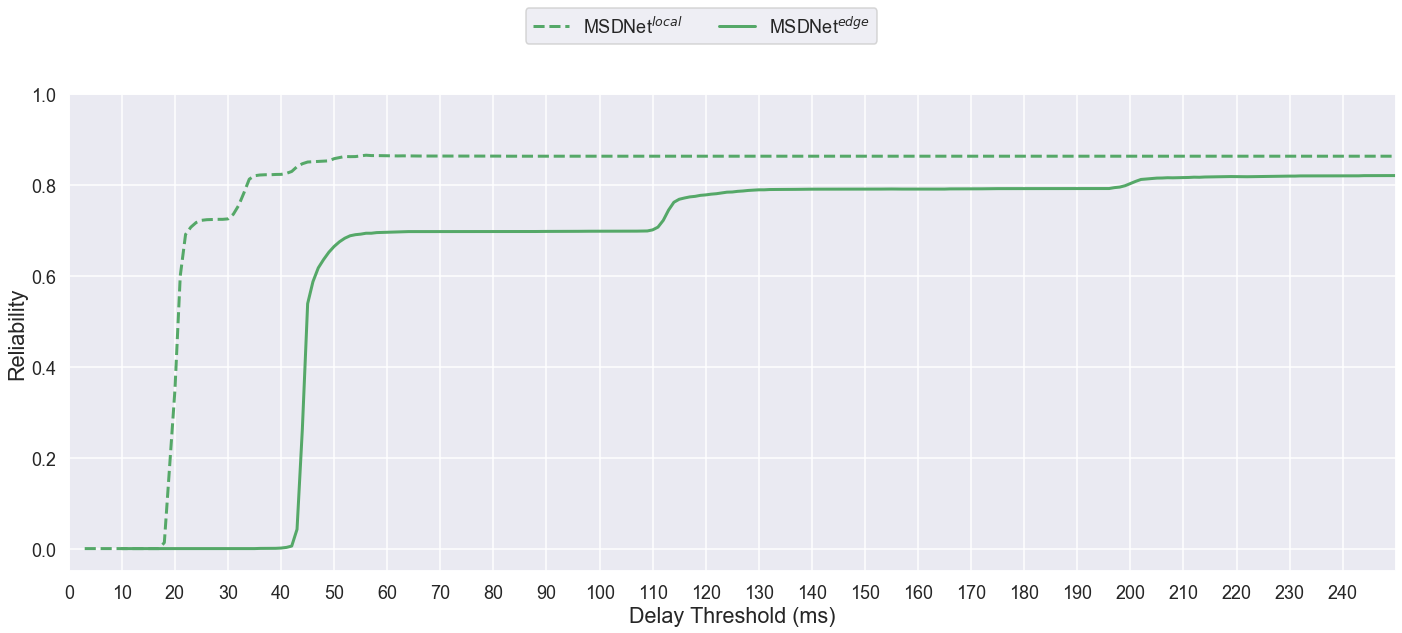

In [903]:

kwargs = {'linewidth': 3}
for platform in platforms[:2]:
    
    #for model, color in zip(models[:2],[0,1]):
    #    axes.plot(results_offload[model]['Delay Threshold'],results_offload[model]['latest'], '--', color=current_palette[color])
    for model, color, label in zip(models[2:],[0,1,2], labels[2:]):
        fig, axes = plt.subplots(1,1, figsize=(22,9))
        axes.set_xlim([0,250])
        axes.plot(results_th['nuc'][model]['Delay Threshold'],results_th['nuc'][model]['latest'], '--', color=current_palette[color], label=label +'$^{local}$', **kwargs)
        axes.plot(results_offload[platform][model]['Delay Threshold'],results_offload[platform][model]['latest'], color=current_palette[color], label=label +'$^{edge}$',**kwargs)
        if model == 'b-resnet':
            axes.plot(results_th['nuc']['resnet']['Delay Threshold'],results_th['nuc']['resnet']['latest'], '--', color=current_palette[color+3], label='ResNet' +'$^{local}$', **kwargs)
            axes.plot(results_offload[platform]['resnet']['Delay Threshold'],results_offload[platform]['resnet']['latest'], color=current_palette[color+3], label='ResNet' +'$^{edge}$', **kwargs)
        if model == 'b-densenet':
            axes.plot(results_th['nuc']['densenet']['Delay Threshold'],results_th['nuc']['densenet']['latest'], '--', color=current_palette[color+5], label='DenseNet' +'$^{local}$', **kwargs)
            axes.plot(results_offload[platform]['densenet']['Delay Threshold'],results_offload[platform]['densenet']['latest'], color=current_palette[color+5], label='DenseNet' +'$^{edge}$', **kwargs)
        axes.set_ylim([-0.05,1])
        axes.set_xticks(np.arange(0,250,10))
        axes.set(xlabel='Delay Threshold (ms)', ylabel='Reliability')
        fig.tight_layout()
        plt.savefig(platform + '_' + model + '_' + 'offloading_vs_local.png')
     
        fig.subplots_adjust(top=0.85, left=0.15) 
        legend = fig.legend(ncol=2, loc="upper center", fontsize='medium')
        export_legend(legend, platform + '_' + model + '_offloading_vs_local_legend.png')
    

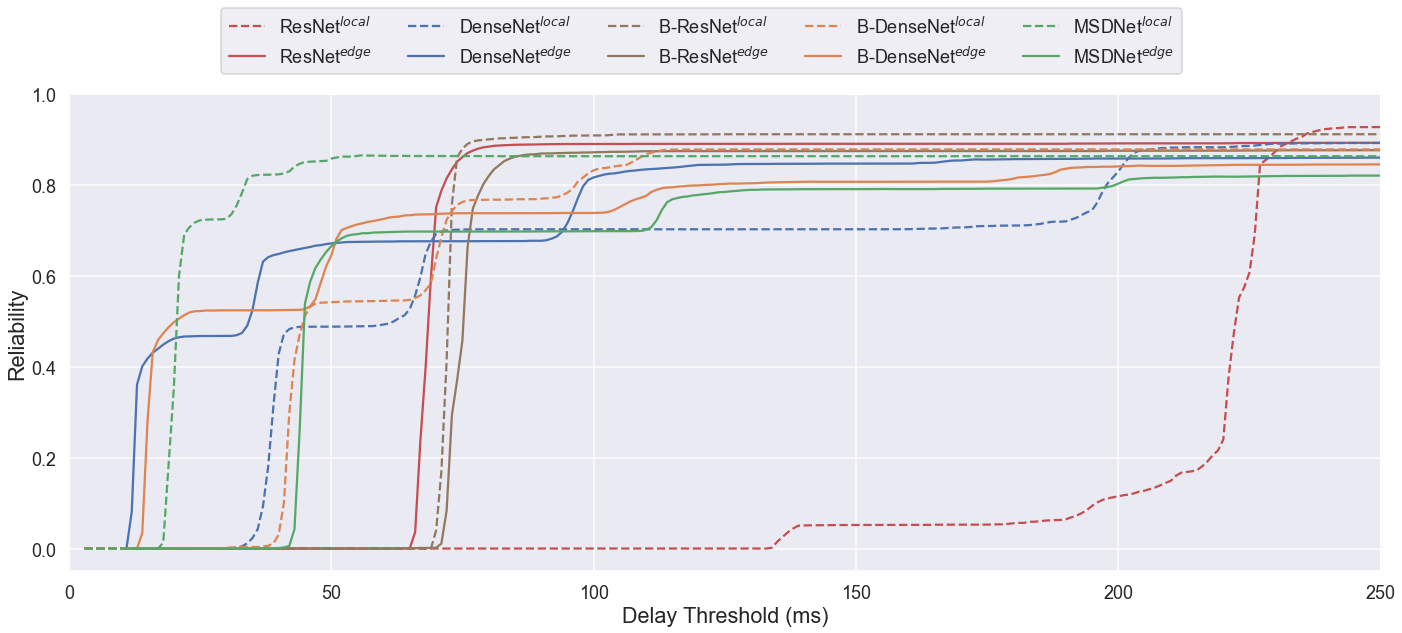

In [824]:
for platform in platforms[1:2]:
    fig, axes = plt.subplots(1,1, figsize=(22,9))  
    #for model, color in zip(models[:2],[0,1]):
    #    axes.plot(results_offload[model]['Delay Threshold'],results_offload[model]['latest'], '--', color=current_palette[color])
    for model, color in zip(models[2:],[0,1,2]):
        if model == 'b-resnet':
            axes.plot(results_th['nuc']['resnet']['Delay Threshold'],results_th['nuc']['resnet']['latest'], '--', color=current_palette[color+3])
            axes.plot(results_offload['jetson']['resnet']['Delay Threshold'],results_offload['jetson']['resnet']['latest'], color=current_palette[color+3])
        if model == 'b-densenet':
            axes.plot(results_th['nuc']['densenet']['Delay Threshold'],results_th['nuc']['densenet']['latest'], '--', color=current_palette[color+4])
            axes.plot(results_offload['jetson']['densenet']['Delay Threshold'],results_offload['jetson']['densenet']['latest'], color=current_palette[color+4])
        axes.set_xlim([0,250])
        axes.plot(results_th['nuc'][model]['Delay Threshold'],results_th['nuc'][model]['latest'], '--', color=current_palette[color])
        axes.plot(results_offload['jetson'][model]['Delay Threshold'],results_offload['jetson'][model]['latest'], color=current_palette[color])
        
        axes.set_ylim([-0.05,1])
    #axes.set_xlim([-0.1,300])
        axes.set(xlabel='Delay Threshold (ms)', ylabel='Reliability')
    #fig.legend(ncol=5, 
    #           loc="upper center", fontsize='small')
        fig.tight_layout()

    
       # plt.savefig(model + '_' + 'offloading_vs_local.png')
    fig.subplots_adjust(top=0.85, left=0.15)  
legend = fig.legend([val for sublist in [['{}'.format(x)+'$^{local}$' ]+ ['{}'.format(x) + '$^{edge}$'] for x in labels] for val in sublist], ncol=5, loc="upper center", fontsize='medium')
export_legend(legend, 'offloading_vs_local_legend.png')

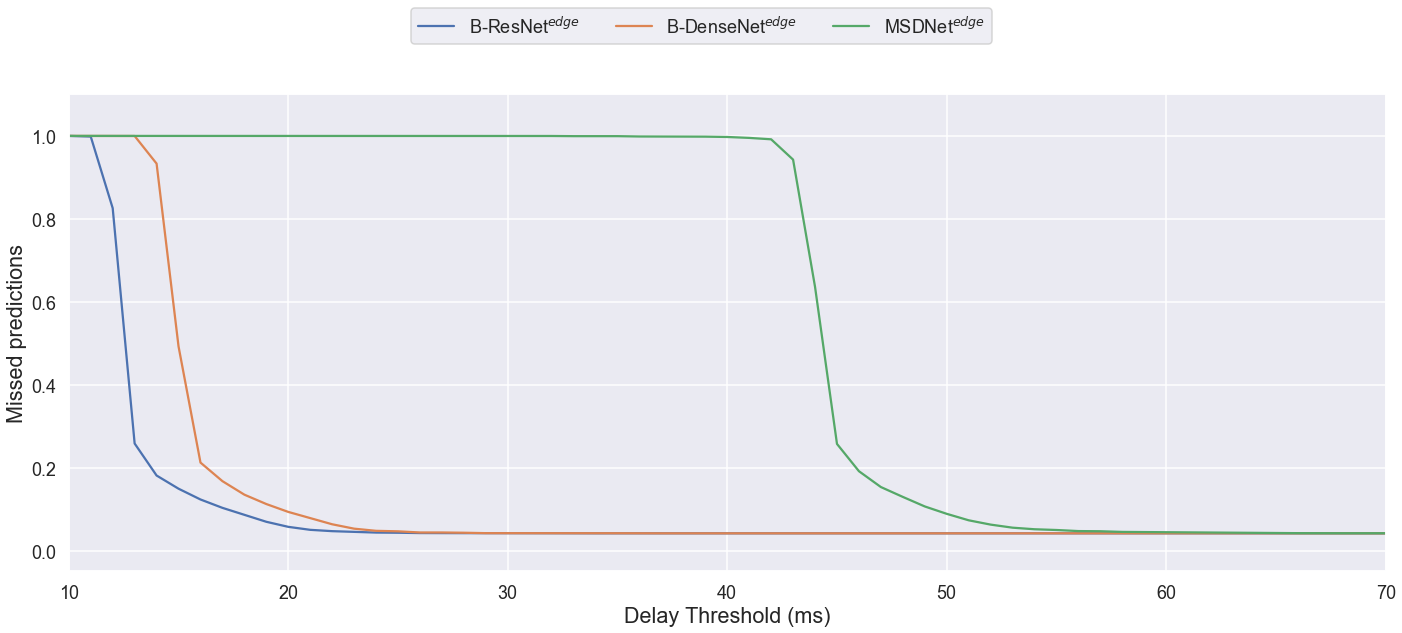

In [771]:
for platform in platforms[1:2]:
    fig, axes = plt.subplots(1,1, figsize=(22,9))
    #for model, color in zip(models[:2],[0,1]):
    #    axes.plot(results_offload[model]['Delay Threshold'],results_offload[model]['latest'], '--', color=current_palette[color])
    for model, color in zip(models[2:],[0,1,2]):
        axes.plot(results_offload[platform][model]['Delay Threshold'],results_offload[platform][model]['missed'] / 5000, color=current_palette[color])
    axes.set_ylim([-0.05,1.1])
    axes.set_xlim([10,70])
    axes.set(xlabel='Delay Threshold (ms)', ylabel='Missed predictions')
    #fig.legend(ncol=5, 
    #           loc="upper center", fontsize='small')
    fig.tight_layout()


    plt.savefig(platform + '_' + 'offloading_missed.png')
    fig.subplots_adjust(top=0.85, left=0.15)  
    legend = fig.legend([label + '$^{edge}$' for label in labels[2:]], ncol=3, loc="upper center", fontsize='medium')
    #export_legend(legend, 'offloading_legend.png')